In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio

In [2]:
stores = pd.read_csv('stores.csv')
train_sales = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')



In [3]:
train_sales.shape

(421570, 5)

In [4]:
test.shape

(115064, 4)

## EDA

In [5]:
train_sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
train_sales['Date'].value_counts()

Date
2011-12-23    3027
2011-11-25    3021
2011-12-16    3013
2011-12-09    3010
2012-02-17    3007
              ... 
2010-07-09    2903
2010-07-16    2901
2010-08-20    2901
2010-08-27    2898
2010-08-13    2896
Name: count, Length: 143, dtype: int64

In [7]:
train_sales['Store'].nunique()

45

In [8]:
train_sales['Dept'].nunique()

81

In [9]:
features.info()
features.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


(8190, 12)

In [10]:
features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [11]:
features.head()


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [12]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [13]:
store_type_dummies = pd.get_dummies(stores['Type'], prefix = 'Store_Type', drop_first=True)
stores= pd.concat([stores, store_type_dummies], axis = 1)
stores

,Store,Type,Size,Store_Type_B,Store_Type_C
0,1,A,151315,False,False
1,2,A,202307,False,False
2,3,B,37392,True,False
3,4,A,205863,False,False
4,5,B,34875,True,False
5,6,A,202505,False,False
6,7,B,70713,True,False
7,8,A,155078,False,False
8,9,B,125833,True,False
9,10,B,126512,True,False


## This is my merged dataset, compared to the professor's down below

In [14]:
# # merge train datasets for easier cleaning and analysis
consolidate_data1 = pd.merge(train_sales, features, on=['Store', 'Date','IsHoliday'], how='left')
train_df = pd.merge(consolidate_data1, stores, on=['Store'], how='left')
train_df.shape


(421570, 18)

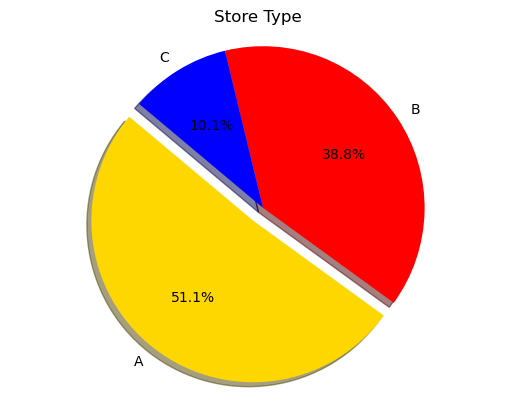

In [15]:
labels = 'A', 'B', 'C'
sizeb = sum(train_df['Store_Type_B'])/len(train_df['Type'])
sizec = sum(train_df['Store_Type_C'])/len(train_df['Type'])
sizea =  1 - sizeb - sizec
sizes = [sizea,sizeb,sizec]  # Percentages of each segment
colors = ['gold', 'Red', 'Blue']
explode = (0.1, 0, 0)  # explode 1st slice (i.e. 'Bank Deposits')

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Store Type')
plt.show()

# This is professor's merged data

In [16]:
df_join = train_sales.groupby(["Store","Dept"]).sum(1).reset_index()[["Store","Dept"]].merge(features, on = ["Store"], how="right").merge(train_sales.drop(columns="IsHoliday"), on = ["Store","Dept","Date"], how="left")
df_join

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales
0,1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,24924.50
1,1,2,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,50605.27
2,1,3,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,13740.12
3,1,4,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,39954.04
4,1,5,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,32229.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606237,45,94,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,NaN
606238,45,95,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,NaN
606239,45,96,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,NaN
606240,45,97,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,NaN


In [17]:
# drop date greater than max date in train data
max_date = np.max(train_sales.Date)
print(max_date)
df_join = df_join[df_join["Date"]<=max_date].reset_index(drop=True)
print(df_join.shape)
df_join.head(2)

2012-10-26
(476333, 14)


,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales
0,1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,24924.50
1,1,2,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,50605.27


In [18]:
df_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476333 entries, 0 to 476332
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         476333 non-null  int64  
 1   Dept          476333 non-null  int64  
 2   Date          476333 non-null  object 
 3   Temperature   476333 non-null  float64
 4   Fuel_Price    476333 non-null  float64
 5   MarkDown1     168943 non-null  float64
 6   MarkDown2     123431 non-null  float64
 7   MarkDown3     152700 non-null  float64
 8   MarkDown4     149148 non-null  float64
 9   MarkDown5     169881 non-null  float64
 10  CPI           476333 non-null  float64
 11  Unemployment  476333 non-null  float64
 12  IsHoliday     476333 non-null  bool   
 13  Weekly_Sales  421570 non-null  float64
dtypes: bool(1), float64(10), int64(2), object(1)
memory usage: 47.7+ MB


In [19]:
np.sum(df_join.isnull())

/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Store                0
Dept                 0
Date                 0
Temperature          0
Fuel_Price           0
MarkDown1       307390
MarkDown2       352902
MarkDown3       323633
MarkDown4       327185
MarkDown5       306452
CPI                  0
Unemployment         0
IsHoliday            0
Weekly_Sales     54763
dtype: int64

## I tried to work on dates 

In [20]:
df_join['Date'] = pd.to_datetime(df_join['Date'])
df_join['id'] = df_join['Store'].astype(str) + '_' + df_join['Dept'].astype(str) + '_' + df_join['Date'].astype(str)
df_join.info()
# test_df['id'] = test_df['Store'].astype(str) + '_' + test_df['Dept'].astype(str) + '_' + test_df['Date'].astype(str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476333 entries, 0 to 476332
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         476333 non-null  int64         
 1   Dept          476333 non-null  int64         
 2   Date          476333 non-null  datetime64[ns]
 3   Temperature   476333 non-null  float64       
 4   Fuel_Price    476333 non-null  float64       
 5   MarkDown1     168943 non-null  float64       
 6   MarkDown2     123431 non-null  float64       
 7   MarkDown3     152700 non-null  float64       
 8   MarkDown4     149148 non-null  float64       
 9   MarkDown5     169881 non-null  float64       
 10  CPI           476333 non-null  float64       
 11  Unemployment  476333 non-null  float64       
 12  IsHoliday     476333 non-null  bool          
 13  Weekly_Sales  421570 non-null  float64       
 14  id            476333 non-null  object        
dtypes: bool(1), datet

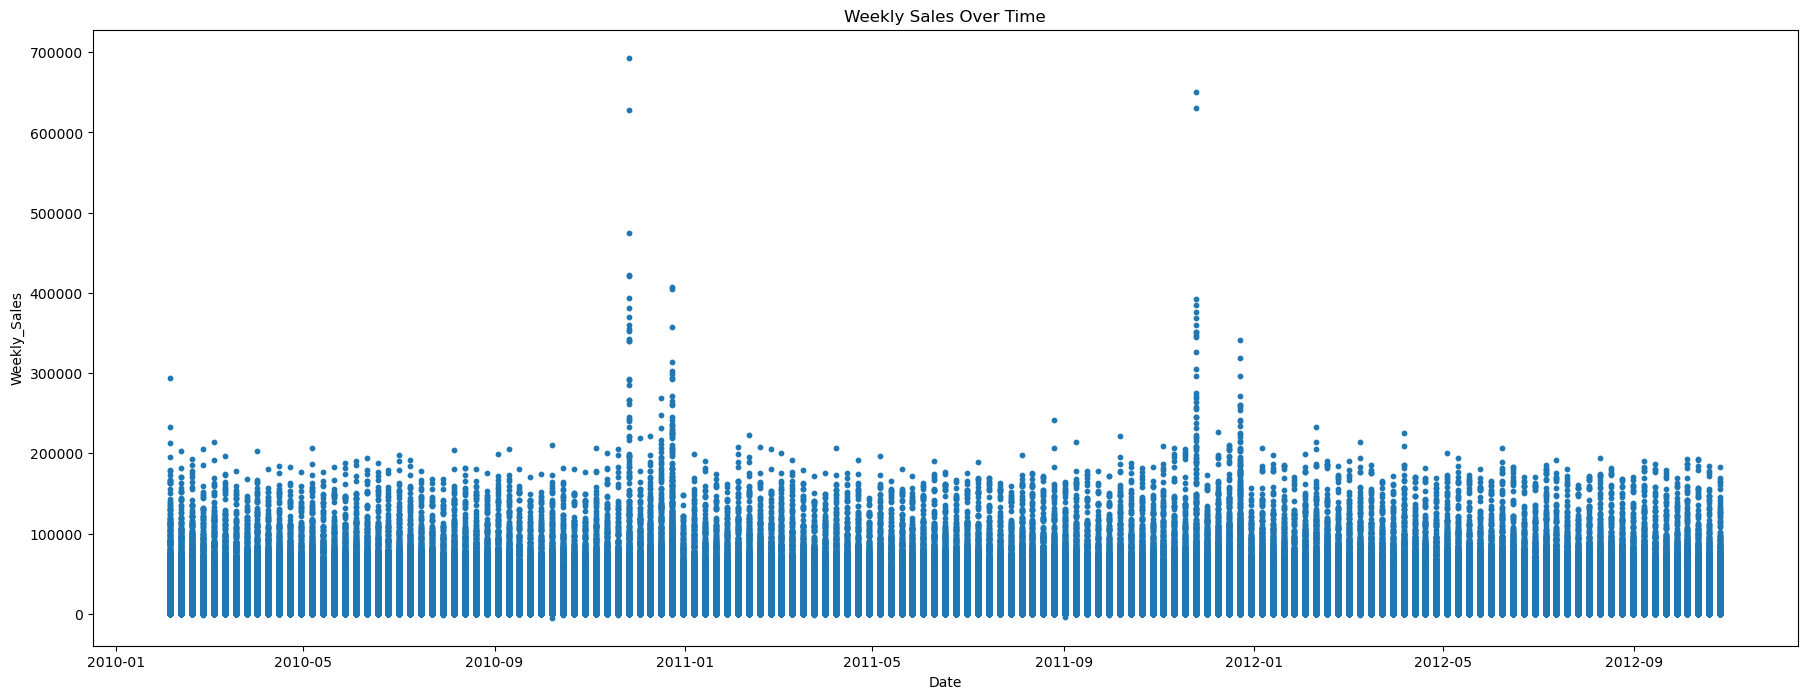

In [21]:
plt.figure(figsize=(22,8))
plt.scatter(df_join['Date'], df_join['Weekly_Sales'], s=10 )
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly_Sales')
plt.show()

In [22]:
# The plot above is too crowded, try to split the dates and look at yearly trend instead.
df_join['Year'] = df_join['Date'].dt.year
df_join['Month'] = df_join['Date'].dt.month
df_join['Week'] = df_join['Date'].dt.isocalendar().week
df_join['Day of the week'] = df_join['Date'].dt.day_name()
df_join.shape

(476333, 19)

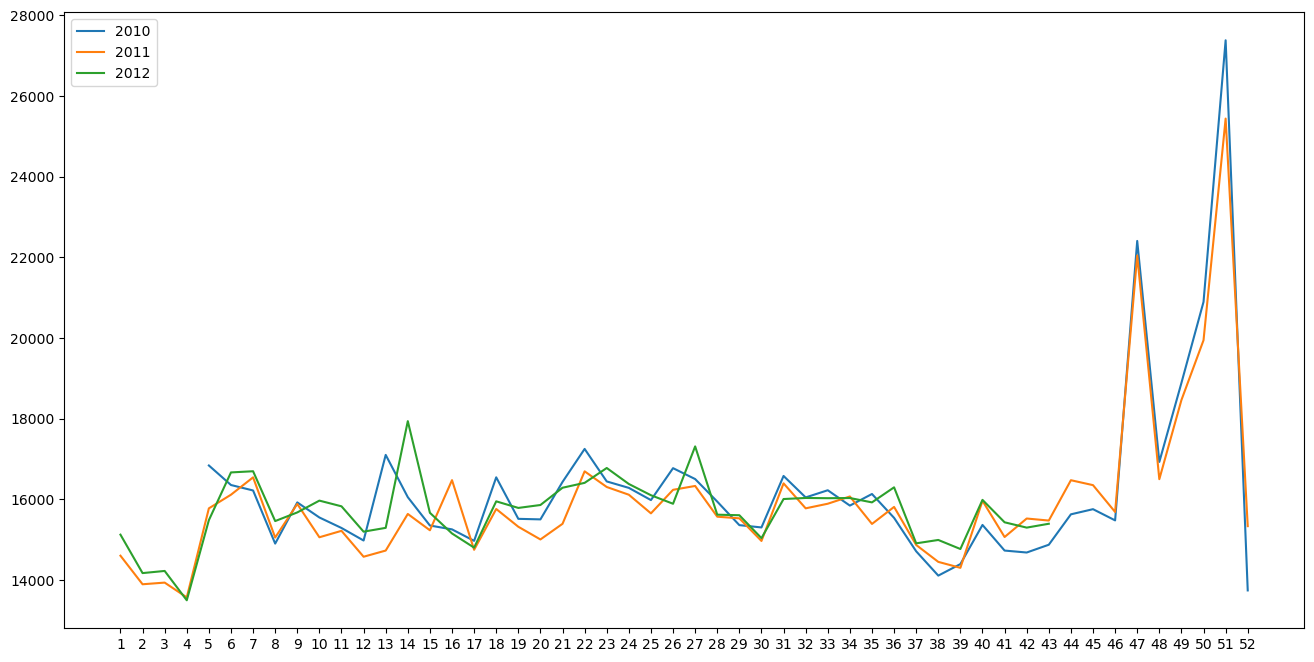

In [23]:
weekly_sales_2010 = df_join[df_join['Year']==2010].groupby('Week')['Weekly_Sales'].mean()
weekly_sales_2011 = df_join[df_join['Year']==2011].groupby('Week')['Weekly_Sales'].mean()
weekly_sales_2012 = df_join[df_join['Year']==2012].groupby('Week')['Weekly_Sales'].mean()
plt.figure(figsize=(16,8))
plt.plot(weekly_sales_2010.index, weekly_sales_2010.values)
plt.plot(weekly_sales_2011.index, weekly_sales_2011.values)
plt.plot(weekly_sales_2012.index, weekly_sales_2012.values)

plt.xticks(np.arange(1,53, step=1), fontsize=10)
plt.legend(['2010','2011','2012'], fontsize=10)
plt.show()

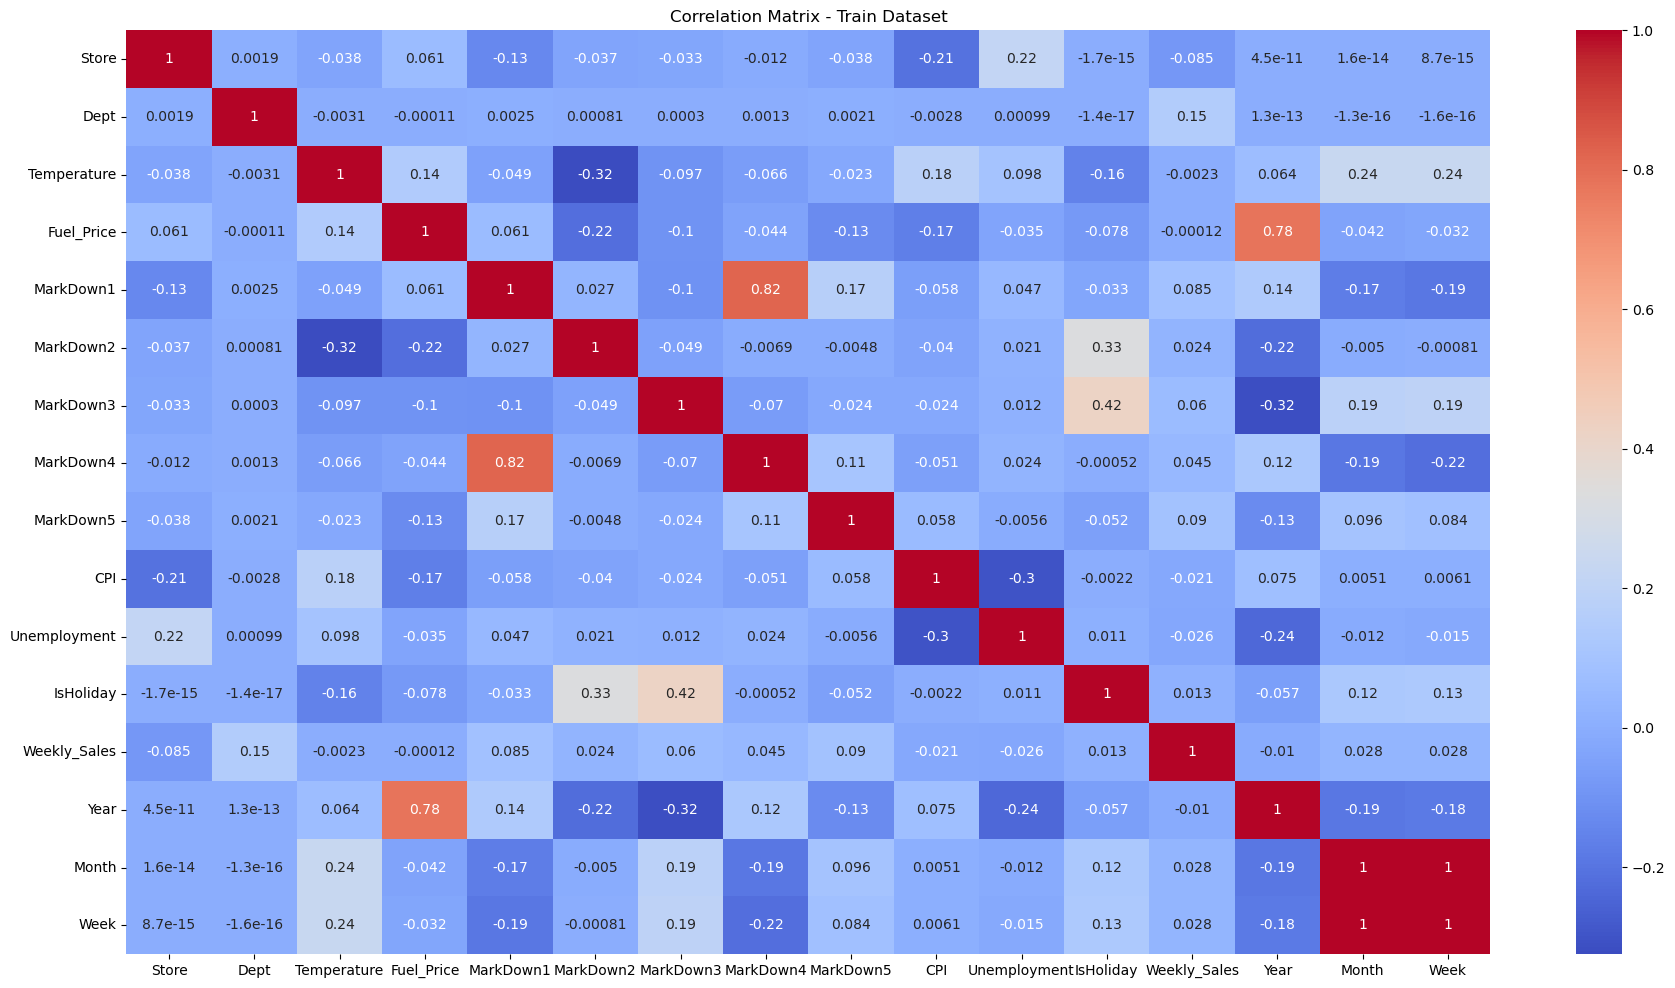

In [24]:
cor_mx= df_join.corr(numeric_only=True)
plt.figure(figsize=(22, 12))
sns.heatmap(cor_mx, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix - Train Dataset')

plt.show()

## Select Store 45 to do more analysis

In [25]:
df_store45 = df_join[(df_join['Store']==45)].reset_index(drop=True)
# df_join["Store"]==45
df_store45.shape

(10582, 19)

In [26]:
df_join.groupby(["Store","Dept"]).sum(1).reset_index()[["Store","Dept"]].Store.value_counts()

Store
19    79
15    79
13    79
20    78
18    78
2     78
11    78
27    78
34    78
4     78
28    77
29    77
32    77
25    77
24    77
40    77
21    77
41    77
1     77
23    77
6     77
14    77
10    77
17    76
16    76
26    76
8     76
31    76
7     76
22    76
12    75
39    75
35    74
45    74
9     73
5     72
3     72
30    64
36    63
38    63
33    63
37    62
42    62
44    62
43    61
Name: count, dtype: int64

In [27]:
np.sum(df_store45.isnull())

/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Store                 0
Dept                  0
Date                  0
Temperature           0
Fuel_Price            0
MarkDown1          6808
MarkDown2          7474
MarkDown3          6956
MarkDown4          6808
MarkDown5          6808
CPI                   0
Unemployment          0
IsHoliday             0
Weekly_Sales        945
id                    0
Year                  0
Month                 0
Week                  0
Day of the week       0
dtype: int64

In [28]:
# pick the first 30 departments without sales, count how many missing records does each Dept have.
df_store45[df_store45.Weekly_Sales.isnull()].Dept.value_counts()[:30]

Dept
96    141
77    135
78    135
47    131
51    121
45    118
49     78
54     32
18     20
80     13
94      9
98      8
58      4
Name: count, dtype: int64

## Look at the plots of weekly sales over dates, obviously there are a lot of missing values.

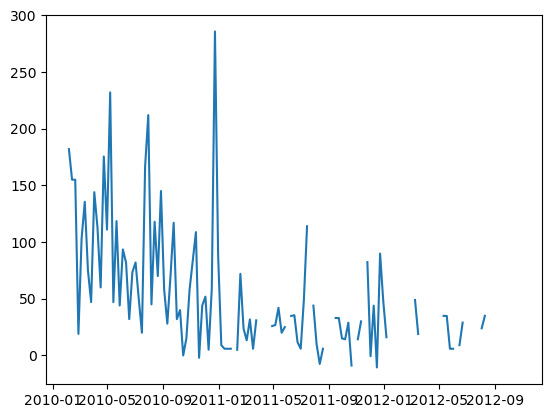

In [29]:

plt.plot(df_store45.loc[df_store45.Dept==54,"Date"], df_store45.loc[df_store45.Dept==54,"Weekly_Sales"])

In [30]:
missing_indices = df_store45.loc[df_store45.Dept==54,"Weekly_Sales"].isnull()
missing_indices

46       False
120      False
194      False
268      False
342      False
         ...  
10258     True
10332    False
10406     True
10480     True
10554    False
Name: Weekly_Sales, Length: 143, dtype: bool

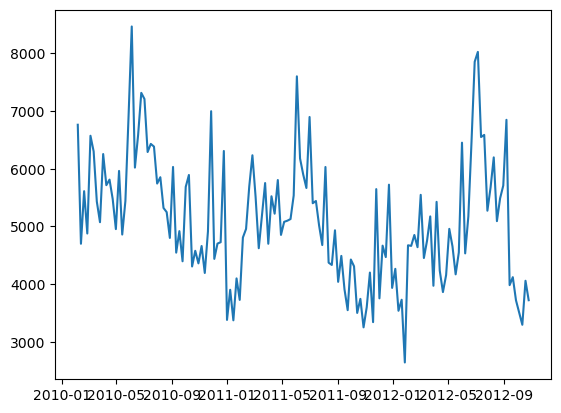

In [31]:
plt.plot(df_store45.loc[df_store45.Dept==20,"Date"], df_store45.loc[df_store45.Dept==20,"Weekly_Sales"])

## Filling missing values with median

In [32]:
df_join_copy1 = df_join.copy()
df_join_copy1.shape

(476333, 19)

In [33]:
df_median = df_join_copy1.groupby(["Store", "Dept"])["Weekly_Sales"].median().reset_index()
df_median.columns = ["Store","Dept","Weekly_Sales_to_fill"]
df_median

,Store,Dept,Weekly_Sales_to_fill
0,1,1,18535.480
1,1,2,45561.850
2,1,3,10366.850
3,1,4,36579.960
4,1,5,21183.420
...,...,...,...
3326,45,94,4120.155
3327,45,95,52417.470
3328,45,96,2.970
3329,45,97,6470.520


In [34]:
df_join_copy1 = df_join_copy1.merge(df_median, on = ["Store", "Dept"])
df_join_copy1.shape

(476333, 20)

In [35]:
df_join_copy1.loc[df_join_copy1["Weekly_Sales"].isnull(),"Weekly_Sales"] = df_join_copy1.loc[df_join_copy1["Weekly_Sales"].isnull(),"Weekly_Sales_to_fill"]

In [36]:
np.sum(df_join_copy1.isnull())

/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Store                        0
Dept                         0
Date                         0
Temperature                  0
Fuel_Price                   0
MarkDown1               307390
MarkDown2               352902
MarkDown3               323633
MarkDown4               327185
MarkDown5               306452
CPI                          0
Unemployment                 0
IsHoliday                    0
Weekly_Sales                 0
id                           0
Year                         0
Month                        0
Week                         0
Day of the week              0
Weekly_Sales_to_fill         0
dtype: int64

### After filling out missing values, look at the same plot again

In [37]:
df_store45 = df_join_copy1[(df_join_copy1['Store']==45)]

In [38]:
np.sum(df_store45.isnull())

Store                      0
Dept                       0
Date                       0
Temperature                0
Fuel_Price                 0
MarkDown1               6808
MarkDown2               7474
MarkDown3               6956
MarkDown4               6808
MarkDown5               6808
CPI                        0
Unemployment               0
IsHoliday                  0
Weekly_Sales               0
id                         0
Year                       0
Month                      0
Week                       0
Day of the week            0
Weekly_Sales_to_fill       0
dtype: int64

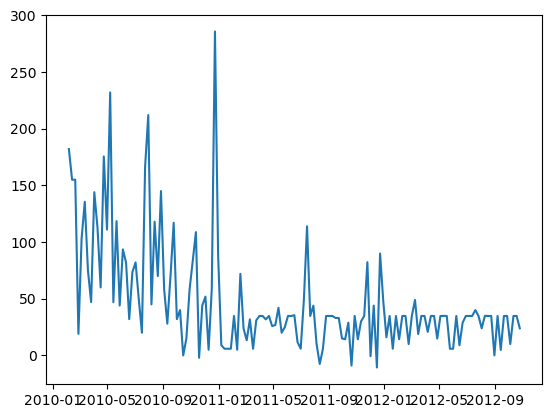

In [39]:
plt.plot(df_store45.loc[df_store45.Dept==54,"Date"], df_store45.loc[df_store45.Dept==54,"Weekly_Sales"])

### Last Observation Carried Forward (LOCF) - Forward Fill missing values
Same method applies if we use backward fill bfill()

In [40]:
df_join_copy2 = df_join.copy()
df_join_copy2

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,id,Year,Month,Week,Day of the week
0,1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,24924.50,1_1_2010-02-05,2010,2,5,Friday
1,1,2,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,50605.27,1_2_2010-02-05,2010,2,5,Friday
2,1,3,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,13740.12,1_3_2010-02-05,2010,2,5,Friday
3,1,4,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,39954.04,1_4_2010-02-05,2010,2,5,Friday
4,1,5,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,32229.38,1_5_2010-02-05,2010,2,5,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476328,45,94,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,5203.31,45_94_2012-10-26,2012,10,43,Friday
476329,45,95,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,56017.47,45_95_2012-10-26,2012,10,43,Friday
476330,45,96,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,NaN,45_96_2012-10-26,2012,10,43,Friday
476331,45,97,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,6817.48,45_97_2012-10-26,2012,10,43,Friday


In [41]:
# Apply ffill within each group but keep the DataFrame structure intact
df_join_copy2['Weekly_Sales'] = df_join_copy2.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.ffill())

# Now df_join_copy2 contains the original data along with the forward-filled 'Weekly_Sales'
df_join_copy2

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,id,Year,Month,Week,Day of the week
0,1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,24924.50,1_1_2010-02-05,2010,2,5,Friday
1,1,2,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,50605.27,1_2_2010-02-05,2010,2,5,Friday
2,1,3,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,13740.12,1_3_2010-02-05,2010,2,5,Friday
3,1,4,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,39954.04,1_4_2010-02-05,2010,2,5,Friday
4,1,5,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,32229.38,1_5_2010-02-05,2010,2,5,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476328,45,94,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,5203.31,45_94_2012-10-26,2012,10,43,Friday
476329,45,95,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,56017.47,45_95_2012-10-26,2012,10,43,Friday
476330,45,96,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,2.94,45_96_2012-10-26,2012,10,43,Friday
476331,45,97,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,6817.48,45_97_2012-10-26,2012,10,43,Friday


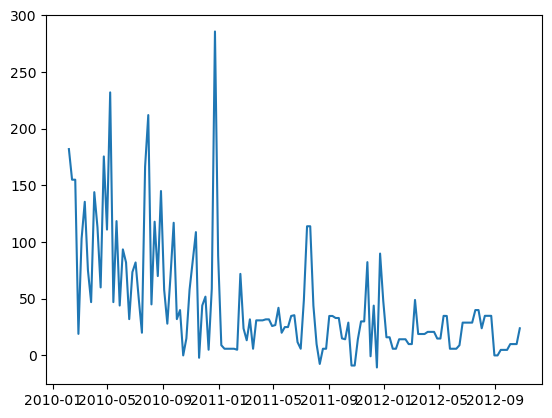

In [42]:
df_store45 = df_join_copy2[(df_join_copy2['Store']==45)]
plt.plot(df_store45.loc[df_store45.Dept==54,"Date"], df_store45.loc[df_store45.Dept==54,"Weekly_Sales"])

### Rolling Statistics Imputation
From the plot we learned that the outcome is not very good. 

In [43]:
df_join_copy3 = df_join.copy()

# Apply the rolling mean imputation method
df_join_copy3['Weekly_Sales'] = df_join_copy3['Weekly_Sales'].fillna(df_join_copy3['Weekly_Sales'].rolling(window=5, min_periods=1).mean().shift(1))
df_join_copy3

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,id,Year,Month,Week,Day of the week
0,1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,24924.500,1_1_2010-02-05,2010,2,5,Friday
1,1,2,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,50605.270,1_2_2010-02-05,2010,2,5,Friday
2,1,3,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,13740.120,1_3_2010-02-05,2010,2,5,Friday
3,1,4,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,39954.040,1_4_2010-02-05,2010,2,5,Friday
4,1,5,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,32229.380,1_5_2010-02-05,2010,2,5,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476328,45,94,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,5203.310,45_94_2012-10-26,2012,10,43,Friday
476329,45,95,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,56017.470,45_95_2012-10-26,2012,10,43,Friday
476330,45,96,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,26929.634,45_96_2012-10-26,2012,10,43,Friday
476331,45,97,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,6817.480,45_97_2012-10-26,2012,10,43,Friday


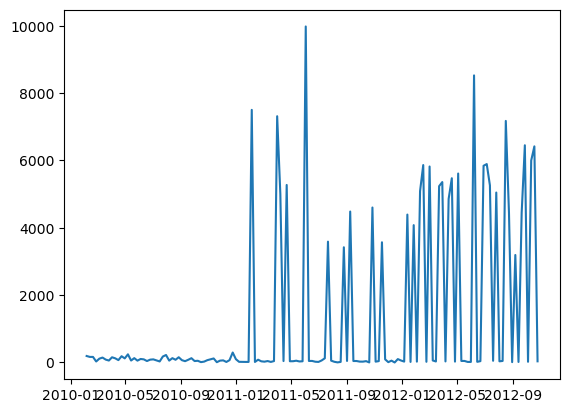

In [44]:
df_store45 = df_join_copy3[(df_join_copy3['Store']==45)]
plt.plot(df_store45.loc[df_store45.Dept==54,"Date"], df_store45.loc[df_store45.Dept==54,"Weekly_Sales"])

### K-Nearest Neighbors (KNN) Imputation


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


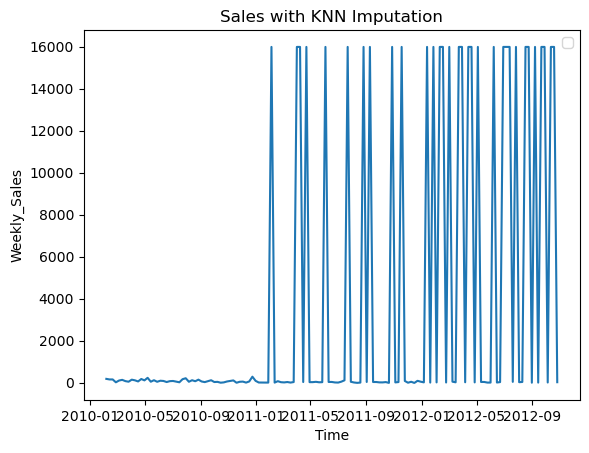

In [45]:
# Initialize the KNN imputer with k=5
imputer = KNNImputer(n_neighbors=3)

# Apply the KNN imputer. Note: the KNNImputer requires 2D array-like input, hence the double brackets.
df_imputed = df_join.copy()
df_imputed[['Weekly_Sales']] = imputer.fit_transform(df_imputed[['Weekly_Sales']])

# Create a matplotlib plot
plt.figure()

df_store45 = df_imputed[(df_imputed['Store']==45)]
plt.plot(df_store45.loc[df_store45.Dept==54,"Date"], df_store45.loc[df_store45.Dept==54,"Weekly_Sales"])

# # Add points where data was imputed
# sns.scatterplot(x="Date", y="Weekly_Sales", data=df_store45, c=['r'])

# Set title and labels
plt.title('Sales with KNN Imputation')
plt.xlabel('Time')
plt.ylabel('Weekly_Sales')
plt.legend()
plt.show()

### Detect Outliers
Use the dataset with imputed median values

In [49]:
df_iqr = df_join_copy1.groupby(["Store","Dept"]).agg(percentile_25 = ('Weekly_Sales',lambda x: x.quantile(0.25)), 
                                                     percentile_75 = ('Weekly_Sales',lambda x: x.quantile(0.75))).reset_index()
df_iqr['upper_bound'] = df_iqr['percentile_75'] + 1.5*(df_iqr['percentile_75'] - df_iqr['percentile_25'])
df_iqr['lower_bound'] = df_iqr['percentile_25'] - 1.5*(df_iqr['percentile_75'] - df_iqr['percentile_25'])
df_iqr

,Store,Dept,percentile_25,percentile_75,upper_bound,lower_bound
0,1,1,16494.630,23214.215,33293.5925,6415.2525
1,1,2,44170.460,47612.245,52774.9225,39007.7825
2,1,3,8693.040,12655.610,18599.4650,2749.1850
3,1,4,34887.740,38268.405,43339.4025,29816.7425
4,1,5,17972.590,25653.795,37175.6025,6450.7825
...,...,...,...,...,...,...
3326,45,94,3246.770,4759.250,7027.9700,978.0500
3327,45,95,49467.360,55822.955,65356.3475,39933.9675
3328,45,96,2.970,2.970,2.9700,2.9700
3329,45,97,6048.125,6865.630,8091.8875,4821.8675


In [50]:
df_join_copy1 = df_join_copy1.merge(df_iqr.drop(columns=["percentile_75","percentile_25"]), on = ["Store","Dept"])
print(df_join_copy1.shape)
df_join_copy1.head(2)

(476333, 22)


,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,IsHoliday,Weekly_Sales,id,Year,Month,Week,Day of the week,Weekly_Sales_to_fill,upper_bound,lower_bound
0,1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,...,False,24924.50,1_1_2010-02-05,2010,2,5,Friday,18535.48,33293.5925,6415.2525
1,1,2,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,...,False,50605.27,1_2_2010-02-05,2010,2,5,Friday,45561.85,52774.9225,39007.7825


In [51]:
df_join_copy1['outlier'] = (df_join_copy1['Weekly_Sales'] < df_join_copy1['lower_bound']) | (df_join_copy1['Weekly_Sales'] > df_join_copy1['upper_bound'])
df_join_copy1.head(2)

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Weekly_Sales,id,Year,Month,Week,Day of the week,Weekly_Sales_to_fill,upper_bound,lower_bound,outlier
0,1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,...,24924.50,1_1_2010-02-05,2010,2,5,Friday,18535.48,33293.5925,6415.2525,False
1,1,2,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,...,50605.27,1_2_2010-02-05,2010,2,5,Friday,45561.85,52774.9225,39007.7825,False


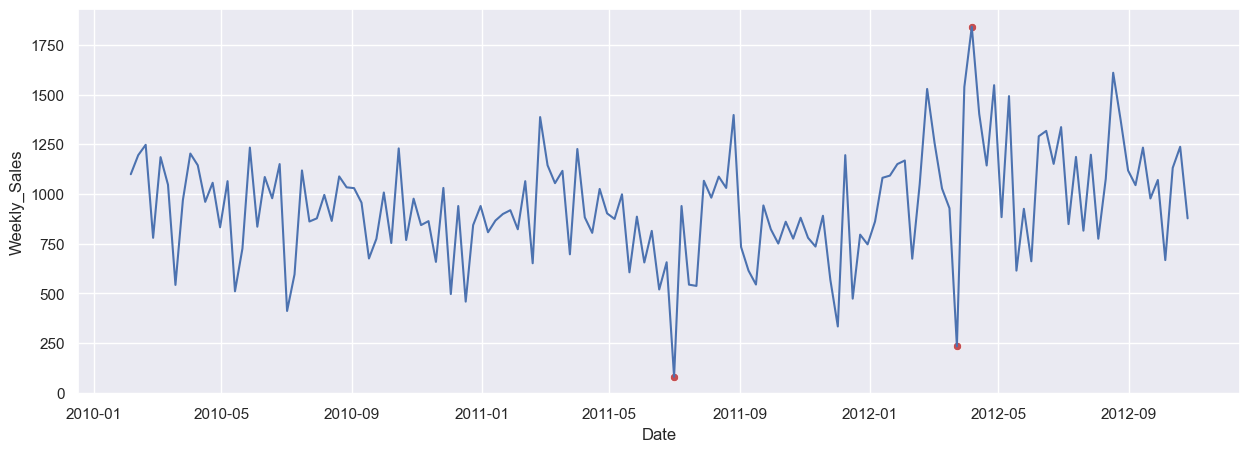

In [52]:
sns.set_theme(rc={'figure.figsize':(15,5)})
df_store19_dept50 = df_join_copy1[(df_join_copy1['Store']==19)&(df_join_copy1['Dept']==50)][["Weekly_Sales","Date"]]
df_store19_dept50_outliers = df_join_copy1[(df_join_copy1['Store']==19)&(df_join_copy1['Dept']==50)&(df_join_copy1['outlier'])][["Weekly_Sales","Date"]]
# plot all the values as a lineplot
sns.lineplot(x="Date", y="Weekly_Sales", data=df_store19_dept50)

# select the data when outlier is True and plot it
sns.scatterplot(x="Date", y="Weekly_Sales", data=df_store19_dept50_outliers, c=['r'])

plt.show()

In [53]:
np.sum(df_join_copy1.outlier)

27165

### Impute Outliers

Thought process: to remove the outliers from Weekly_Sales column, then impute them with rolling statistics for prior 3 periods.

In [54]:
df_join_copy1.loc[df_join_copy1["outlier"],"Weekly_Sales"] = None

In [55]:
np.sum(df_join_copy1.isnull())

/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Store                        0
Dept                         0
Date                         0
Temperature                  0
Fuel_Price                   0
MarkDown1               307390
MarkDown2               352902
MarkDown3               323633
MarkDown4               327185
MarkDown5               306452
CPI                          0
Unemployment                 0
IsHoliday                    0
Weekly_Sales             27165
id                           0
Year                         0
Month                        0
Week                         0
Day of the week              0
Weekly_Sales_to_fill         0
upper_bound                  0
lower_bound                  0
outlier                      0
dtype: int64

In [56]:
df_join_copy1.shape

(476333, 23)

In [57]:
temp  = df_join_copy1.groupby(["Store","Dept"])['Weekly_Sales'].apply(lambda x:x.rolling(window=3, min_periods=1).mean()).reset_index()
temp = temp.drop(columns = ["Store","Dept","level_2"])
temp.columns = ["Weekly_Sales_to_fill_outlier"]
temp 

,Weekly_Sales_to_fill_outlier
0,24924.500000
1,24924.500000
2,24924.500000
3,19403.540000
4,20615.720000
...,...
476328,527.210000
476329,534.590000
476330,732.496667
476331,816.376667


In [58]:
df_join_copy1=df_join_copy1.join(temp)
df_join_copy1

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,id,Year,Month,Week,Day of the week,Weekly_Sales_to_fill,upper_bound,lower_bound,outlier,Weekly_Sales_to_fill_outlier
0,1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,...,1_1_2010-02-05,2010,2,5,Friday,18535.480,33293.5925,6415.2525,False,24924.500000
1,1,2,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,...,1_2_2010-02-05,2010,2,5,Friday,45561.850,52774.9225,39007.7825,False,24924.500000
2,1,3,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,...,1_3_2010-02-05,2010,2,5,Friday,10366.850,18599.4650,2749.1850,False,24924.500000
3,1,4,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,...,1_4_2010-02-05,2010,2,5,Friday,36579.960,43339.4025,29816.7425,False,19403.540000
4,1,5,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,...,1_5_2010-02-05,2010,2,5,Friday,21183.420,37175.6025,6450.7825,False,20615.720000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476328,45,94,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,...,45_94_2012-10-26,2012,10,43,Friday,4120.155,7027.9700,978.0500,False,527.210000
476329,45,95,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,...,45_95_2012-10-26,2012,10,43,Friday,52417.470,65356.3475,39933.9675,False,534.590000
476330,45,96,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,...,45_96_2012-10-26,2012,10,43,Friday,2.970,2.9700,2.9700,False,732.496667
476331,45,97,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,...,45_97_2012-10-26,2012,10,43,Friday,6470.520,8091.8875,4821.8675,False,816.376667


In [59]:
# # df_join_copy1.reset_index(drop=True, inplace=True)
# df_join_copy1['Weekly_Sales'] = df_join_copy1['Weekly_Sales'].fillna(df_join_copy1['Weekly_Sales_to_fill_outlier'])

In [60]:
df_join_copy1.loc[df_join_copy1["Weekly_Sales"].isnull(),"Weekly_Sales"] = df_join_copy1.loc[df_join_copy1["Weekly_Sales"].isnull(),"Weekly_Sales_to_fill_outlier"]

In [61]:
np.sum(df_join_copy1.isnull())

/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Store                                0
Dept                                 0
Date                                 0
Temperature                          0
Fuel_Price                           0
MarkDown1                       307390
MarkDown2                       352902
MarkDown3                       323633
MarkDown4                       327185
MarkDown5                       306452
CPI                                  0
Unemployment                         0
IsHoliday                            0
Weekly_Sales                       410
id                                   0
Year                                 0
Month                                0
Week                                 0
Day of the week                      0
Weekly_Sales_to_fill                 0
upper_bound                          0
lower_bound                          0
outlier                              0
Weekly_Sales_to_fill_outlier      7842
dtype: int64